# Spurious Correlation: Hidden Common Cause

## 1. Conceptual Motivation

Spurious correlation xảy ra khi hai biến X và Y có tương quan thống kê,
nhưng không tồn tại quan hệ nhân quả trực tiếp giữa chúng.

Thay vào đó, cả hai cùng phụ thuộc vào một biến ẩn Z.

Câu hỏi trung tâm:

> Khi nào tương quan chỉ phản ánh một nguyên nhân chung,
> chứ không phải quan hệ trực tiếp giữa hai biến?

Ta sẽ mô phỏng mô hình latent factor:

$$ X = β_x Z + ε_x $$
$$ Y = β_y Z + ε_y $$

Trong đó Z là biến ẩn không quan sát.

In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from src import (
    generate_latent_factor_data,
    plot_spurious_scatter
)

sns.set_theme(style="whitegrid")
pd.set_option("display.precision", 4)

## 2. Data-Generating Process

In [2]:
df = generate_latent_factor_data(
    n=2000,
    beta_x=1.0,
    beta_y=1.0,
    noise_std=1.0,
    seed=42
)

df.head()

,X,Y,Z
0,-0.1472,0.5579,0.3047
1,-1.7059,-0.1448,-1.0400
2,1.1845,1.0238,0.7505
3,1.1924,3.1794,0.9406
4,-3.3558,-0.5212,-1.9510


## 3. Observed Correlation (Ignoring Z)

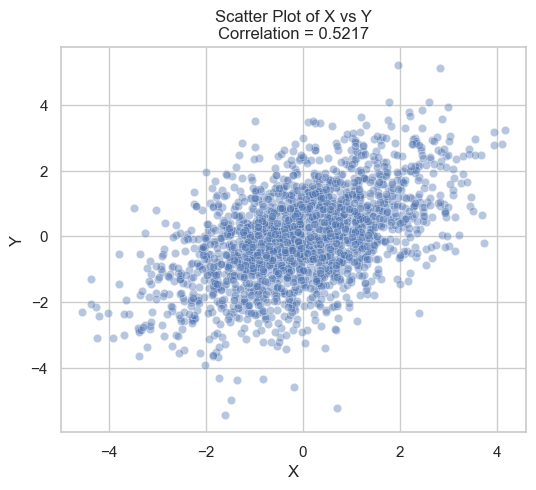

np.float64(0.5216623415457998)

In [3]:
corr = plot_spurious_scatter(df)
corr

Tương quan quan sát được:

$$ Corr(X, Y) ≈ 0.522 $$

Điều này cho thấy mối quan hệ tuyến tính dương ở mức trung bình.

Trên scatter plot, ta thấy:

- Xu hướng tăng rõ ràng.
- Khi X lớn, Y có xu hướng lớn.
- Phân phối có dạng elip nghiêng lên.

Nếu chỉ quan sát dữ liệu này, ta có thể kết luận:

> X và Y có mối quan hệ tuyến tính đáng kể.

Tuy nhiên, trong mô hình sinh dữ liệu:

$X = β_x Z + ε_x $
$Y = β_y Z + ε_y$

Không tồn tại quan hệ trực tiếp giữa X và Y.

Tương quan này xuất phát hoàn toàn từ việc cả hai cùng phụ thuộc vào Z.

Do đó:

$Corr(X, Y) ≠ $ causal relationship

$Corr(X, Y) = $ common factor effect

## 4. Regression Without Controlling for Z

In [4]:
X_model = sm.add_constant(df["X"])
model_simple = sm.OLS(df["Y"], X_model).fit()

model_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     747.0
Date:                Sun, 01 Mar 2026   Prob (F-statistic):          5.30e-140
Time:                        16:49:57   Log-Likelihood:                -3219.0
No. Observations:                2000   AIC:                             6442.
Df Residuals:                    1998   BIC:                             6453.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0209      0.027     -0.771      0.441      -0.074       0.032
X              0.5222      0.019     27.331      0.000       0.485       0.560
==============================================================================
Omnibus:                        8.766   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               10.876
Skew:                          -0.052   Prob(JB):                      0.00435
Kurtosis:                       3.346   Cond. No.                         1.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 4. Regression Without Controlling for Z

Kết quả hồi quy đơn:

Y = α + βX

- Hệ số β ≈ 0.522
- t ≈ 27.33
- p-value < 0.001
- R² ≈ 0.272

---

### 1. Hệ số có ý nghĩa thống kê rất mạnh

p-value gần như bằng 0.

Điều này cho thấy:

- Ta có thể bác bỏ giả thuyết H₀: β = 0.
- X có vẻ “giải thích” Y.

Nếu chỉ nhìn mô hình này, ta có thể kết luận:

> X có tác động tuyến tính đáng kể lên Y.

---

### 2. R² ≈ 27%

Khoảng 27% phương sai của Y được giải thích bởi X.

Đây là mức khá lớn trong nhiều bối cảnh thực tế.

---

### 3. Nhưng cấu trúc thật sự là gì?

Trong dữ liệu sinh ra:

$X = Z + ε_x$
$Y = Z + ε_y$

Không tồn tại quan hệ trực tiếp giữa X và Y.

Hệ số 0.522 xuất hiện vì:

Cov(X,Y) = Var(Z)

và:

Corr(X,Y) ≈ 0.52

---

### 4. Ý nghĩa quan trọng

Regression này không phát hiện quan hệ nhân quả.

Nó chỉ phát hiện rằng:

X mang thông tin về Z,
và Z quyết định Y.

Do đó:

β̂ ≠ causal effect
β̂ = shared latent factor effect

## 5. Regression Controlling for Hidden Factor

In [5]:
X_full = sm.add_constant(df[["X","Z"]])
model_full = sm.OLS(df["Y"], X_full).fit()

model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     977.1
Date:                Sun, 01 Mar 2026   Prob (F-statistic):          1.23e-296
Time:                        16:49:57   Log-Likelihood:                -2854.2
No. Observations:                2000   AIC:                             5714.
Df Residuals:                    1997   BIC:                             5731.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0129      0.023      0.569      0.570      -0.031       0.057
X              0.0450      0.023      1.986      0.047       0.001       0.089
Z              0.9493      0.032     29.648      0.000       0.887       1.012
==============================================================================
Omnibus:                        7.220   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                8.543
Skew:                          -0.055   Prob(JB):                       0.0140
Kurtosis:                       3.301   Cond. No.                         2.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mô hình đầy đủ:

Y = α + β₁X + β₂Z

Kết quả:

- Hệ số của Z ≈ 0.949  (p < 0.001)
- Hệ số của X ≈ 0.045  (p ≈ 0.047)
- R² tăng từ 0.272 → 0.495

---

### 1. Z giải thích phần lớn biến thiên của Y

Hệ số của Z gần bằng 1,
đúng với cấu trúc sinh dữ liệu:

$ Y = Z + ε_y $

Điều này xác nhận rằng:

Z là nguồn gốc thực sự của biến thiên trong Y.

---

### 2. Hệ số của X sụt giảm mạnh

Trong hồi quy đơn:

$ β̂_X ≈ 0.522 $

Sau khi thêm Z:

$ β̂_X ≈ 0.045 $

Giảm hơn 90%.

Điều này cho thấy:

Phần lớn "tác động" của X trong mô hình đơn
thực chất chỉ là do X mang thông tin về Z.

---

### 3. Vì sao X chưa về đúng 0?

Hệ số của X vẫn hơi khác 0 (≈ 0.045)
và có p-value ≈ 0.047.

Điều này xảy ra do:

- Sai số mẫu (finite sample noise)
- Nhiễu εₓ và εᵧ không hoàn toàn triệt tiêu

Trong giới hạn mẫu lớn, hệ số này sẽ tiến gần 0.

---

### 4. Diễn giải cấu trúc

Ta có:

$X = Z + ε_x $
$Y = Z + ε_y $

Do đó:

- X không gây ra Y
- Z gây ra cả hai

Regression đơn nhầm lẫn X là biến giải thích,
nhưng regression có kiểm soát cho thấy:

> Quan hệ giữa X và Y là spurious.

---

### 5. Kết luận

Spurious correlation không phải là "tương quan giả".

Nó là:

Tương quan thật về mặt thống kê,
nhưng không phản ánh quan hệ nhân quả trực tiếp.

Khi omitted variable (Z) được đưa vào mô hình,
tác động giả của X gần như biến mất.

## 6. Structural Interpretation

Tổng covariance có thể được phân rã:

$$ Cov(X,Y) = E[Cov(X,Y | Z)] + Cov(E[X | Z], E[Y | Z]) $$

Trong mô hình này:

- $ Cov(X,Y | Z) = 0 $
- Tương quan xuất phát hoàn toàn từ $ Cov(E[X|Z], E[Y|Z]) $

Điều này cho thấy:

> Association không hàm ý causation.

Khi kiểm soát Z,
mối quan hệ trực tiếp giữa X và Y biến mất.

## 7. Financial Interpretation (Market Factor Model)

Giả sử:

- X = lợi nhuận cổ phiếu A
- Y = lợi nhuận cổ phiếu B
- Z = market factor

$$ R_A = β_A M + ε_A $$
$$ R_B = β_B M + ε_B $$

Hai cổ phiếu có tương quan cao,
nhưng không phải vì A gây ra B.

Chúng chỉ cùng phản ứng với thị trường.

Spurious correlation trong trường hợp này
là kết quả của omitted variable (market factor).